In [1]:
import operator
# https://github.com/DEAP/deap/issues/491
import gym
import numpy as np
from deap import algorithms, base, creator, gp, tools
from scoop import futures
import pygraphviz as pgv
import matplotlib.pyplot as plt
import math
import imageio

def print_img(img):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.show()

In [2]:
TARGET_EMOJI = 0 #@param "🦎"
vision = 1
tests_for_each_tree = 1
n_total_steps = 10
pset = gp.PrimitiveSet("MAIN", ((vision+2)**2)*3) 

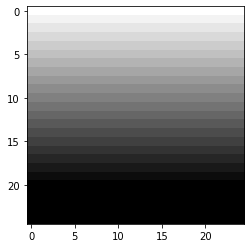

In [3]:
target_img = np.zeros((25,25))
for i in range(25):
    target_img[i][:] = 1 - (i*5)/100
# target_img = load_emoji(TARGET_EMOJI)
print_img(target_img)

In [4]:
############################################ Image functions ################################################
def to_rgb(x):
    # assume rgb premultiplied by alpha
    rgb, a = x[..., :3], to_alpha(x)
    return np.clip(1.0-a+rgb, 0, 0.9999)

def to_alpha(x):
    return np.clip(x[..., 3:4], 0, 0.9999)

def to_gray(x):
    rgb = to_rgb(x)
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def load_emoji(index, path="data/emoji.png"):
    im = imageio.imread(path)
    emoji = np.array(im[:, index*40:(index+1)*40].astype(np.float32))
    emoji /= 255.0
    gray_emoji = to_gray(emoji)
    return gray_emoji

def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.show()

def create_base_env(target_image):
    env = np.copy(target_image)
    env = np.pad(np.copy(target_image), 1)
    env[:] = 1.0
    a, b = env.shape
    env[int(a/2)][int(b/2)] = 0.5
    return env
    
def draw_graph(expr):
    nodes, edges, labels = gp.graph(expr)
    g = pgv.AGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    g.layout(prog="dot")

    for i in nodes:
        n = g.get_node(i)
        n.attr["label"] = labels[i]
    g.draw('out.png')

In [5]:
# Adding functions
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.abs, 1)


def protected_div(a, b):
    if b == 0:
        return 1
    else: 
        return a/b
    
def limit(input, minimum, maximum):
    if input < minimum:
        return minimum
    elif input > maximum:
        return maximum
    else:
        return input

def if_then_else(input, output1, output2):
    if input: return output1
    else: return output2

pset.addPrimitive(protected_div, 2)
pset.addPrimitive(limit, 3)
pset.addPrimitive(if_then_else, 3)
# Adding constants
pset.addTerminal(0)
pset.addTerminal(1)
pset.addTerminal(0.1)

In [6]:
############################################ Automata  ################################################
sobel_x = [[-1, 0, +1], [-2, 0, +2], [-1, 0, +1]]
sobel_y = np.transpose(sobel_x)

class CA_2D_model:
    def __init__(self, length, width, individual, *, vision=1 ):
        self.action = toolbox.compile(individual)
        self.len = length + 2*vision
        self.wid = width + 2*vision
        self.vision = vision
        self.vision_size = (vision+2)**2

        # The size of the pad is dependent on how far each cell sees to updates its valus
        self.original = np.pad(np.zeros((length, width)),1)
        self.original[:] = 1    
        self.original[int(self.len/2)][int(self.wid/2)] = 0

        self.ca = np.copy(self.original)
    
    def reset_ca(self):
        self.ca = np.copy(self.original)

        
    def get_observation(self, i, j):
        observation = self.ca[i-self.vision:i+self.vision+1, j-self.vision:j+self.vision+1]
        x = np.multiply(sobel_x, observation) # apply sobel filter for edge detection
        y = np.multiply(sobel_y, observation) # apply sobel filter for edge detection
        return np.append(observation.reshape(-1), [x.reshape(-1), y.reshape(-1)])
    
    def new_cell_value(self, i, j):
        if i-self.vision < 0 or j-self.vision < 0:
            return
        if i+self.vision >= self.len or j + self.vision >= self.wid:
            return

        observation = self.get_observation(i, j)
        if observation[0:self.vision_size].sum() >= 1 * self.vision_size: # checking if the cell is alive
            return 1.
        return self.action(*observation)

    def update(self):
        new_ca = np.copy(self.ca)
        for i in range(self.vision, self.len - self.vision): # skipping pad
            for j in range(self.vision, self.wid - self.vision): # skipping pad
                new_ca[i, j] = self.new_cell_value(i, j)
        if (new_ca == self.ca).all():
            return False
        self.ca = new_ca
        return True
        
    def remove_pad(self):
        return self.ca[self.vision:self.len - self.vision, self.vision:self.wid - self.vision]

    def loss(self, target_image):
        ca = self.remove_pad()
        if target_image.shape != ca.shape:
            raise
        loss = 0
        for i in range(target_image.shape[0]):
            for j in range(target_image.shape[1]):
                if ca[i,j] > 1 or ca[i,j] < 0 or math.isnan(ca[i,j]):
                    return 100
                l = ca[i,j] - target_image[i,j]
                loss += l**2
        return loss

In [12]:
def eval_individual(individual, render=False):
    shape = target_img.shape
    ca = CA_2D_model(shape[0], shape[1], individual)
    
    total_loss = 0.0
    for i in range(tests_for_each_tree):
        ca.reset_ca()

        for _ in range(n_total_steps):
            if render:
                print_img(ca.ca)
                print(ca.loss(target_img))
            update = ca.update()
            if not update: # the automata got stable
                break

        loss = ca.loss(target_img)
        total_loss += loss  

    
    l = total_loss / tests_for_each_tree
    return (l,)

In [8]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Tree generator
toolbox.register("tree_generator", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)

# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.tree_generator)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [9]:
#toolbox.register("map", futures.map)
toolbox.register("evaluate", eval_individual)
toolbox.register("select", tools.selTournament, tournsize=7)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [13]:
pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.2, 30, stats=mstats,
                               halloffame=hof, verbose=True)
draw_graph(hof[0])
eval_individual(hof[0], True)

/tmp/ipykernel_17529/2690056855.py:12: RuntimeWarning: overflow encountered in double_scalars
  return a/b
/tmp/ipykernel_17529/2175249706.py:26: RuntimeWarning: invalid value encountered in multiply
  x = np.multiply(sobel_x, observation) # apply sobel filter for edge detection
/tmp/ipykernel_17529/2175249706.py:27: RuntimeWarning: invalid value encountered in multiply
  y = np.multiply(sobel_y, observation) # apply sobel filter for edge detection


   	      	                    fitness                    
   	      	-----------------------------------------------
gen	nevals	avg   	gen	max   	min	nevals	std    
0  	100   	220.58	0  	330.55	100	100   	89.8804
1  	87    	143.003	1  	307.05	100	87    	80.757 
2  	81    	139.823	2  	307.05	100	81    	77.5987


/tmp/ipykernel_17529/2690056855.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return a/b


3  	83    	115.604	3  	309.55	100	83    	51.5989
4  	85    	128.17 	4  	326.35	100	85    	70.379 
5  	91    	125.408	5  	307.05	100	91    	66.3811
6  	79    	117.969	6  	307.05	100	79    	57.4166
7  	85    	132.261	7  	315.05	100	85    	72.3058
8  	86    	110.245	8  	306.25	100	86    	42.2949
9  	88    	128.297	9  	309.293	100	88    	69.2078
10 	75    	125.279	10 	307.05 	100	75    	62.8619
11 	85    	116.935	11 	307.05 	100	85    	52.8292
12 	83    	122.906	12 	326.35 	100	83    	63.515 


KeyboardInterrupt: 

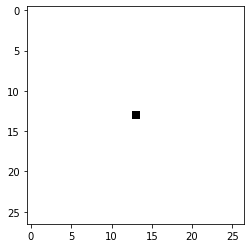

306.0499999999998


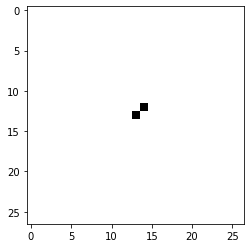

100


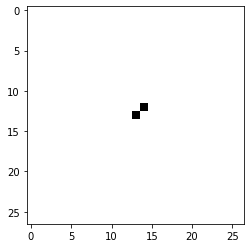

100


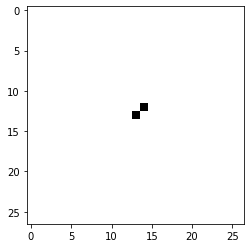

100


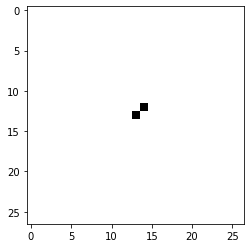

100


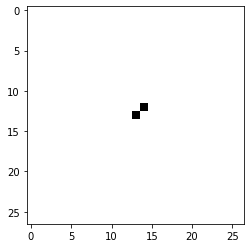

100


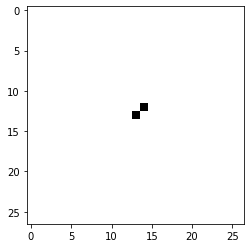

100


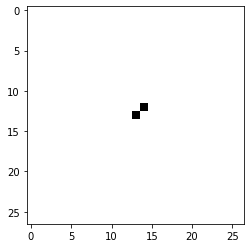

100


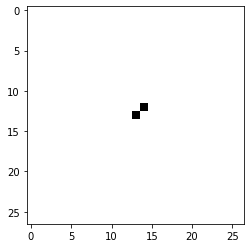

100


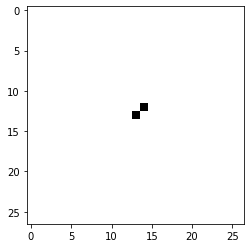

100


(100.0,)

In [11]:
eval_individual(hof[0], True)